In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt

import geomstats.backend as gs
import geomstats.visualization as visualization


from geomstats.learning.frechet_mean import FrechetMean
from geomstats.geometry.matrices import Matrices, MatricesMetric

from geomstats.geometry.symmetric_matrices import SymmetricMatrices
from geomstats.geometry import spd_matrices

INFO: Using numpy backend


In [2]:
from statsmodels.tsa.arima_process import ArmaProcess

In [3]:
import pandas as pd

In [4]:
#s=1
# define the manifold to be d*d spd matrix, d = 3
d = 3
mfd = spd_matrices.SPDMetricAffine(n=d, power_affine=1)
aux= spd_matrices.SPDMatrices(n=d)


def generate_sample_tangent_space(base=gs.eye(d), n_samples=1, sigma=1):
    # generate i.i.d gaussian noise on tangent space
    size = (n_samples, d, d) if n_samples != 1 else (d, d)
    tangent_vec_at_id_aux = gs.random.normal(scale=sigma, size=size)
    tangent_vec_at_id = 0.5 * (tangent_vec_at_id_aux + Matrices.transpose(
        tangent_vec_at_id_aux
    ))
    # sqrt_base_point = gs.linalg.sqrtm(base_point)
    return tangent_vec_at_id


def generate_random_sample(base=gs.eye(d), n_samples=1, sigma=1):
    # generate sample with Frechet mean equal the given base point.
    tv = generate_sample_tangent_space(base=base, n_samples=n_samples, sigma=sigma)
    return mfd.exp(tangent_vec=tv, base_point=base)


def generate_ar_ts(base=gs.eye(d), n_samples=1, sigma=1, rho=0.5,burn = 500,tau=1):
    # generate AR(1)  process X_t -mu = rho(t/n)(X_{t-1}-mu)+epsilon
    if n_samples == 1:
        return generate_sample_tangent_space(base=base, n_samples=1, sigma=1)
    else:
        data_tv = np.zeros((n_samples, d, d))
        delta = generate_sample_tangent_space(base=base, n_samples=1, sigma=1)
        
        for j in range(burn):
            rhotmp =  rho
    
            noise =  generate_sample_tangent_space(base=gs.eye(d), n_samples=1, sigma=sigma)
            delta = rhotmp*delta+noise
            
        data_tv[0,:,:] =  delta
        
        for i in range(1, n_samples):
            u =i/n_samples
            rhotmp = rho+ tau*(0.2*np.cos(2*u*np.pi)+u*(1-u)) 
            #rhotmp =  rho
            inten = sigma*(0.5 + tau*u**2)
            delta = data_tv[i - 1, :, :]
            #inten =  sigma*(1+u**2)
            noise = generate_sample_tangent_space(base=gs.eye(d), n_samples=1, sigma=inten)
            data_tv[i, :, :] = rhotmp * (delta) + noise
        data = mfd.exp(tangent_vec=data_tv, base_point=base)
        return data


def E_comp(mu):
    sqrt_mu = gs.linalg.sqrtm(mu)
    E = np.zeros((6, 3, 3))
    k = 0
    for i in range(3):
        for j in range(i, 3):
            eiej = np.zeros((3, 3))
            if (i == j):
                eiej[i, i] = 1
                # E[k,:,:]=np.dot(sqrt_mu,np.dot(eiej,sqrt_mu))
            else:
                eiej[i, j] = eiej[j, i] = 1 / np.sqrt(2)

            E[k, :, :] = np.dot(sqrt_mu, np.dot(eiej, sqrt_mu))

            k = k + 1
    return E

def coordinate(mu, E, V):
    # mu: base point
    # E: orthonormal base
    # V: tangent vector
    v = np.zeros(6)
    for k in range(6):
        v[k] = mfd.inner_product(V, E[k], mu)
    return v

def coortomat(mu, E, y):
    # mu: base point
    # E: orthonormal base
    # V: tangent vector
    # y = np.zeros(6)
    V = np.zeros((3, 3))
    for k in range(6):
        V = V + y[k] * E[k]
    return V


In [5]:
def ar(rho, T, d):
    ar_process = np.zeros((T, d))
    for l in range(d):
        ar = ArmaProcess(np.array([1, -rho]), np.array([1]))
        ar_process[:, l] = ar.generate_sample(nsample=T)
    return ar_process

In [26]:

## test case
# bp = gs.eye(d)
# data = generate_ar_ts(base=bp,n_samples=1000, sigma=1, rho=0.5,burn = 500)
# fmean = FrechetMean(metric=mfd,max_iter=200000,epsilon=1e-10)
# fmean.fit(data)
# mean =fmean.estimate_
#residual =  mfd.log(point=data,base_point=mean) 

In [4]:
import numpy.fft as fft
import scipy.stats as stats

In [10]:
from tqdm import tqdm_notebook as tqdm

In [11]:
tau_lst = [2]
T_lst = [128,256,512,1024]
#T_lst = [2048]   

for a in range(len(tau_lst)):
    for b in range(len(T_lst)):
        tau = tau_lst[a]
        T =T_lst[b]# sample size
       
        m =  8
        bp = gs.eye(d)
        n = T // m  # 64
        repli_s =5000
        L = n//2+1
        u = (n * np.arange(m) + n / 2) / T
        omega = 2 * np.pi * np.arange(1, n + 1) / n
        sigma=1
        d_intrinsic = 6 # dimension 
        rho=0.1
        z = np.zeros(repli_s)
        for kk in tqdm(range(repli_s)):
            np.random.seed(kk)
            data = generate_ar_ts(bp,n_samples=T,sigma=sigma,rho=rho,burn=500,tau=tau)
            fmean = FrechetMean(metric=mfd,max_iter=200000,epsilon=1e-10)
            
            
            fmean.fit(data)
            mean =fmean.estimate_
            residual=  mfd.log(point=data,base_point=bp) 
            E = E_comp(bp)


            xx = np.zeros((T,6))
            for i in range(T):
                xx[i]  = coordinate(bp, E, residual[i])
            #xx = ar(rho=0.01, T=T, d=6)
            x = xx - np.mean(xx, axis=0)

            D_my = np.zeros((m,L,6),dtype=complex)
            for i in range(m):
                low = i*n
                up = (i+1)*n

                D_my[i] =fft.fft(x[low:up],axis=0)[0:L]#/ np.sqrt(2 * np.pi * n)
                #D_my[i] =fft.rfft(x[low:up],axis=0)[0:L]/np.sqrt(2*np.pi*n)
            D_my_conj = np.conj(D_my)
            D_mynorm = np.mean(np.abs(D_my)**2,axis=2)

            #  <D(uj,wk),D(uj,wk-1) >  1<=j<=m, 1<=k<= n/2    <m*(n/2)*d, m*(n/2)*d> ---> m*(n/2)
            inner_products = np.mean(D_my_conj[:,0:(L-1),:] * D_my[:, 1:L, :], axis=2)
            #inner_products2 = np.sum(D_conj[:,1:L,:] * D[:, 1:L, :], axis=2)
            F1hat =  np.sum(np.square(np.abs(inner_products)))/T

            V = D_my[:, 1:L, :]  # This has the shape (16, 8, 6) #D(u_j,lambda_k) : j=1,...,m, k =1,...,n/2
            V_conj_transpose = np.conj(V)  # This is the complex conjugate 

            # Prepare the arrays for outer product calculation using broadcasting
            # Add a new axis to V for broadcasting to work correctly for the outer product
            V = V[:, :, :, np.newaxis]  # This will have the shape (16, 8, 6, 1)
            V_conj_transpose = V_conj_transpose[:, :, np.newaxis, :]  # This will have the shape (16, 8, 1, 6)

            # Now compute the outer product
            Imat = V * V_conj_transpose/d_intrinsic # I(u_j,lambda_k) : j=1,...,m, k =1,...,n/2

            Ilambda = np.mean(Imat,axis=0) # mean of I over u (n/2)*(d*d)
            Il_sq = np.sum(np.abs(Ilambda)**2,axis=(1,2))#  ||mean of I over u ||_2 : vector in R^m

            F2hat= Il_sq.mean()/2
            Bhat = np.sum(D_mynorm[:,0:(L-1)]*D_mynorm[:,1:L])/T
            mhat = (F1hat-F2hat+Bhat/m)
            #mhat = F1_hat-F2_hat
            vhat =np.sqrt(np.sum(np.mean(np.abs(inner_products)**2,axis=0)**2)/n)
            z[kk] = np.sqrt(T)*mhat/vhat

        np.save('zval_sigma_'+str(sigma)+'rho_'+str(rho)+'T_'+str(T)+'m_'+str(m)+'tau_'+str(tau)+'_AR_power.npy',z)
        print(np.mean(z>stats.norm.ppf(0.95)))

/var/folders/xl/kgnxbxpd1tl1dxlkp0qvtb180000gn/T/ipykernel_64302/4033162078.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for kk in tqdm(range(repli_s)):


  0%|          | 0/5000 [00:00<?, ?it/s]

0.9248


  0%|          | 0/5000 [00:00<?, ?it/s]

0.9482


  0%|          | 0/5000 [00:00<?, ?it/s]

0.9886


  0%|          | 0/5000 [00:00<?, ?it/s]

0.9992


In [5]:
tau_lst = [0,0.25,0.5,0.75,1,1.5]
T_lst = [256,512,1024]
m=8 
#n = T // m  # 64
repli_s =5000
#L = n//2+1
#u = (n * np.arange(m) + n / 2) / T
#omega = 2 * np.pi * np.arange(1, n + 1) / n
sigma=0.75
d_intrinsic = 6 # dimension 
rho=0.1
zlst = []
for a in range(len(tau_lst)):
    for b in range(len(T_lst)):
        tau = tau_lst[a]
        T =T_lst[b]# sample size
        znow = np.load('zval_sigma_'+str(sigma)+'rho_'+str(rho)+'T_'+str(T)+'m_'+str(m)+'tau_'+str(tau)+'_AR_power.npy')
        znow=np.mean(znow>stats.norm.ppf(0.95))
        zlst.append((tau, T, znow))

In [11]:
zlst

[(0, 256, 0.085),
 (0, 512, 0.0728),
 (0, 1024, 0.07),
 (0.25, 256, 0.2488),
 (0.25, 512, 0.3026),
 (0.25, 1024, 0.4106),
 (0.5, 256, 0.6114),
 (0.5, 512, 0.7672),
 (0.5, 1024, 0.9306),
 (0.75, 256, 0.8236),
 (0.75, 512, 0.9474),
 (0.75, 1024, 0.9952),
 (1, 256, 0.9056),
 (1, 512, 0.9822),
 (1, 1024, 0.9992)]

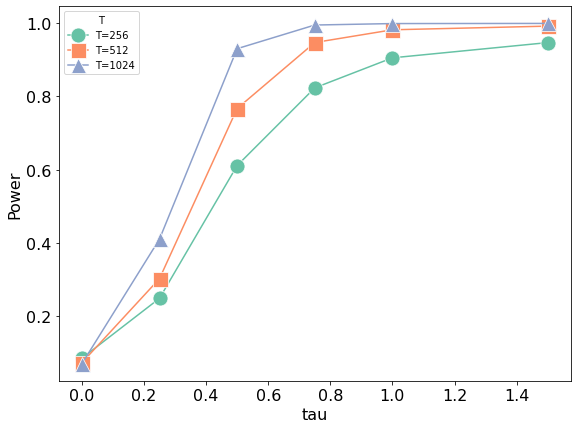

In [10]:
z_array = np.array(zlst, dtype=[('tau', 'f4'), ('T', 'f4'), ('z', 'f4')])

# Creating a DataFrame for seaborn
z_df = pd.DataFrame(z_array)
palette = sns.color_palette("Set2")  # You can choose other palettes
markers = ["o", "s", "^", "D", "x", "*", "P"]  # Different marker styles
plt.figure(figsize=(8, 6))
for i, (T, grp) in enumerate(z_df.groupby('T')):
    sns.lineplot(data=grp, x='tau', y='z', label=f'T={int(T)}',
                 color=palette[i % len(palette)], marker=markers[i % len(markers)],markersize=15)

#plt.title('Power curves for second order stationarity test in SPD matrices', fontsize=15)
plt.xlabel('tau',size=16)
plt.ylabel('Power',size=16)
plt.legend(title='T')
plt.tight_layout()
plt.tick_params(axis='both', which='major', labelsize=16) 
plt.savefig('Second_order_spd.png',facecolor='w')
# # Plot using seaborn
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=z_df, x='T', y='z', hue='tau', marker='o')
# plt.title('Z values over T for different tau')
# plt.xlabel('T')
# plt.ylabel('Z value')
# plt.legend(title='tau')
# plt.show()

In [16]:
z_array

array([(0.  ,  256., 0.085 ), (0.  ,  512., 0.0728),
       (0.  , 1024., 0.07  ), (0.25,  256., 0.2488),
       (0.25,  512., 0.3026), (0.25, 1024., 0.4106),
       (0.5 ,  256., 0.6114), (0.5 ,  512., 0.7672),
       (0.5 , 1024., 0.9306), (0.75,  256., 0.8236),
       (0.75,  512., 0.9474), (0.75, 1024., 0.9952),
       (1.  ,  256., 0.9056), (1.  ,  512., 0.9822),
       (1.  , 1024., 0.9992), (1.5 ,  256., 0.9472),
       (1.5 ,  512., 0.9922), (1.5 , 1024., 0.9996)],
      dtype=[('tau', '<f4'), ('T', '<f4'), ('z', '<f4')])

In [110]:
np.mean(z>stats.norm.ppf(0.95)) #T= 64:0.8094

0.8244

In [98]:
np.mean(z>stats.norm.ppf(0.95)) # T=128

0.8244

In [90]:
z0=np.load('zval_sigma_'+str(1)+'rho_'+str(0.15)+'T_'+str(1024)+'m_'+str(8)+'_AR_power.npy')

In [88]:
mean

array([[ 1.07618912,  0.24869318,  0.13267895],
       [ 0.24869318,  1.06603276, -0.10699586],
       [ 0.13267895, -0.10699586,  1.15287863]])

In [86]:
z_mat = np.zeros((5000,4))
T_lst = [64,128,256,512]
for l in range(4):
    T= T_lst[l]
    z_mat[:,l]=np.load('zval_sigma_'+str(1)+'rho_'+str(0.15)+'T_'+str(T)+'m_'+str(8)+'_AR_power.npy')

In [96]:
np.mean(z_mat>=stats.norm.ppf(0.95),axis=0),

(array([0.7008, 0.6616, 0.689 , 0.7968]),)